In [2]:
# import necessary libraries
import pandas as pd
import re
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np
import json
import folium
from folium.plugins import HeatMap
import os

In [3]:
def load_config(path):
    with open(path, 'r') as file:
        return json.load(file)

config_path = '../pandas_config.json'
config = load_config(config_path)
parquet_config = config['parquet']

# setting up the engine as a global constant
ENGINE = parquet_config['engine']
COMPRESSION = parquet_config['compression']
FILE_PATH = "../data/data_parquet"

In [4]:
data = pd.read_parquet(FILE_PATH + "/processed_data_combined.parquet", engine=ENGINE)

/var/folders/vm/vj250x0s5q9bj_4nnx_z8mcc0000gn/T/ipykernel_92861/1256871056.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='user_name', y='activity_count', data=user_activity, palette='Blues_r')


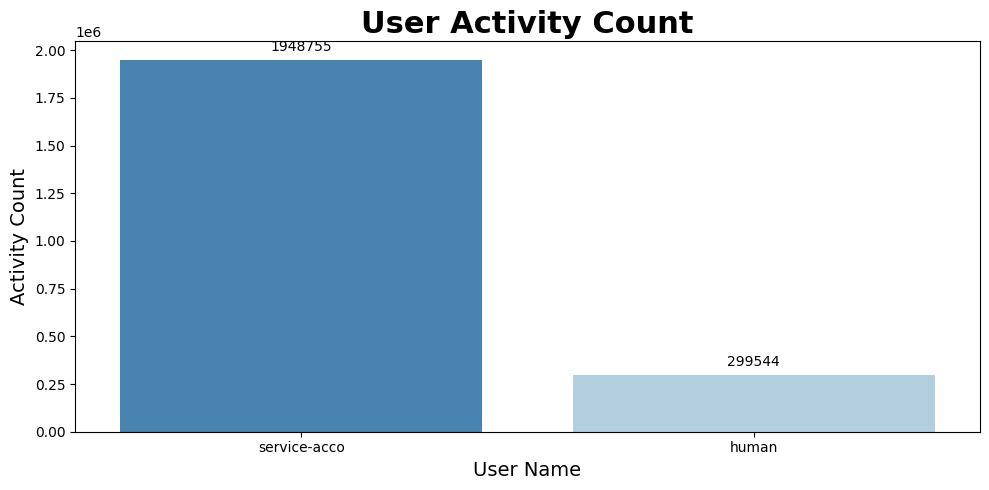

In [5]:
# count actions per user
user_activity = data['user_name'].value_counts().reset_index()
user_activity.columns = ['user_name', 'activity_count']

# plot the activity count for each user
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='user_name', y='activity_count', data=user_activity, palette='Blues_r')

# add text labels on the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize = 10)

plt.title('User Activity Count', fontsize=22, fontweight='bold')
plt.xlabel('User Name', fontsize=14)
plt.ylabel('Activity Count', fontsize=14)

plt.savefig('./graphics/user_activity_count.svg', format="svg")

plt.tight_layout()
plt.show()

In [6]:
# calculate the ratio of activities between users
user_activity['ratio'] = user_activity['activity_count'] / user_activity['activity_count'].sum()

user_activity[['user_name', 'ratio']]


,user_name,ratio
0,service-acco,0.866769
1,human,0.133231


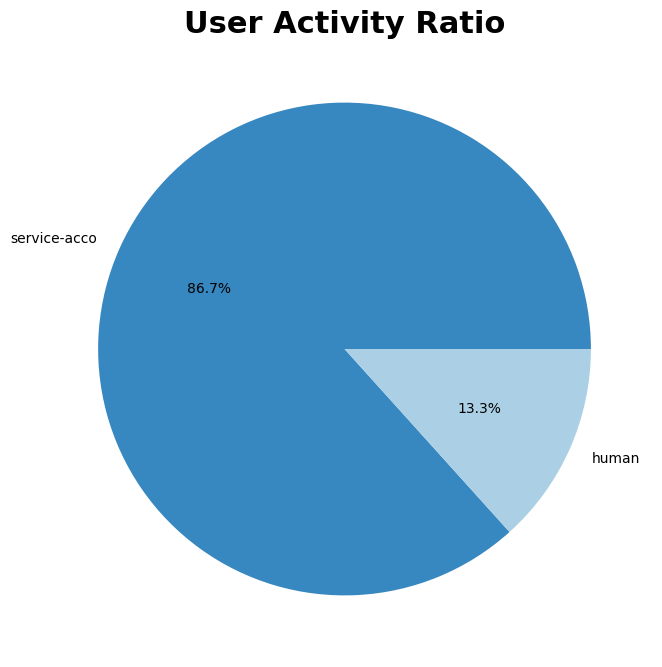

In [7]:
# plot the ratio of activities for each user as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(user_activity['ratio'], labels=user_activity['user_name'], autopct='%1.1f%%', colors=sns.color_palette('Blues_r', len(user_activity)))
plt.title('User Activity Ratio', fontsize=22, fontweight='bold')
plt.savefig('./graphics/user_activity_ratio.svg', format = "svg")

plt.show()

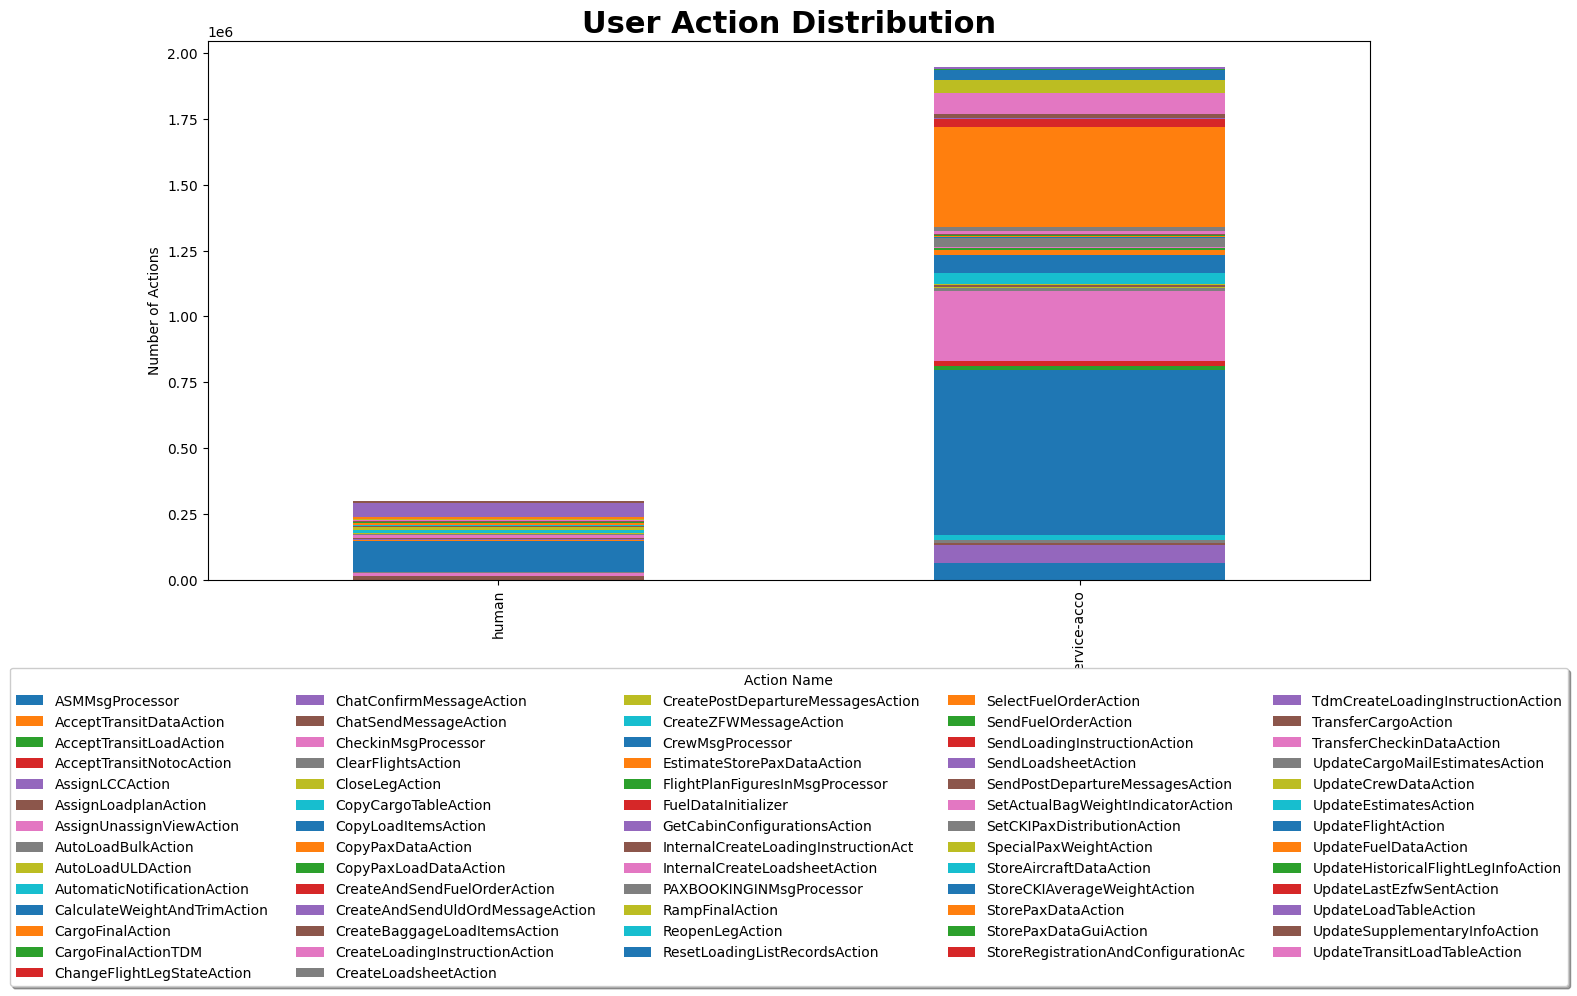

In [8]:
# count actions by type for each user
user_action_counts = data.groupby(['user_name', 'action_name']).size().unstack().fillna(0)

# plot action distribution for each user
ax = user_action_counts.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('User Action Distribution', fontsize=22, fontweight='bold')
plt.xlabel('User Name')
plt.ylabel('Number of Actions')

# move legend below the plot and make it horizontal
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5, title='Action Name')

plt.savefig('./graphics/user_action_distribution.svg', format="svg")

plt.show()

<Figure size 1500x700 with 0 Axes>

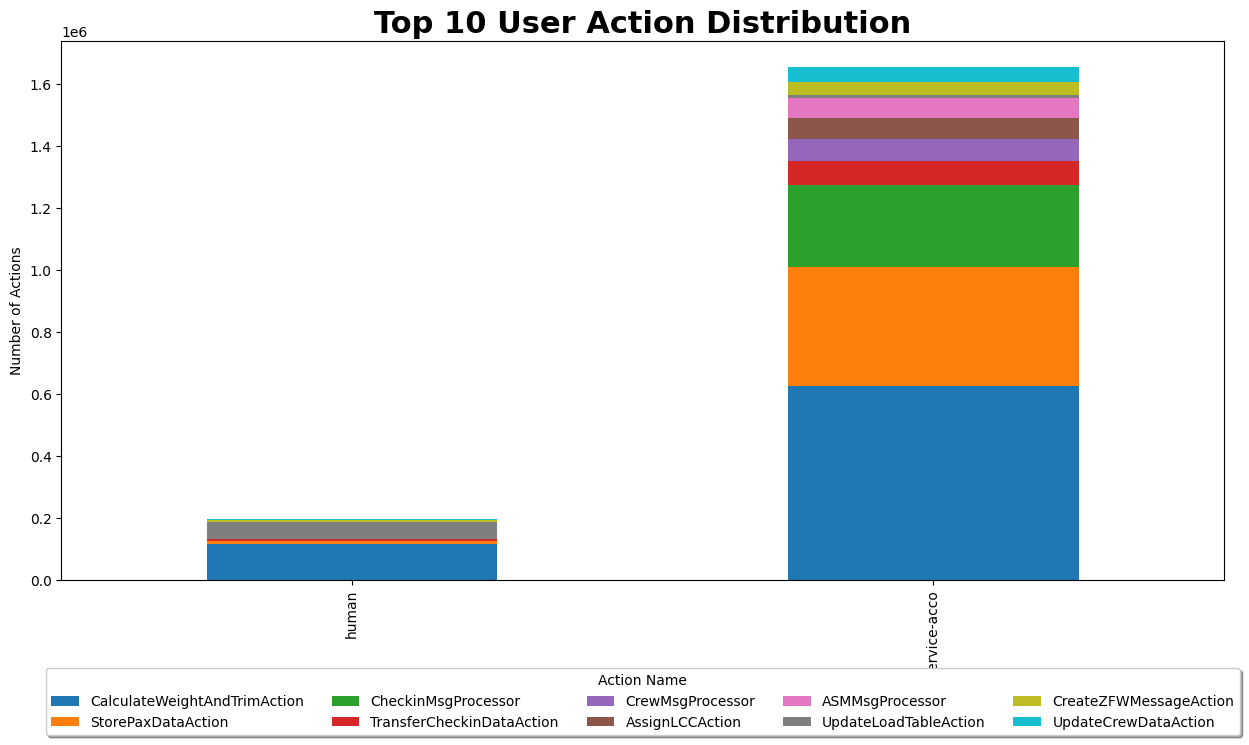

In [9]:
top_actions = user_action_counts.sum().nlargest(10).index

# filter the dataframe to include only the top actions
top_user_action_counts = user_action_counts[top_actions]

# plot action distribution for each user
plt.figure(figsize=(15, 7))
top_user_action_counts.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title(f'Top 10 User Action Distribution', fontsize=22, fontweight='bold')
plt.xlabel('User Name')
plt.ylabel('Number of Actions')

# move legend below the plot and make it horizontal
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=5, title='Action Name')

plt.savefig('./graphics/user_action_distribution_10.svg', format="svg")

plt.show()

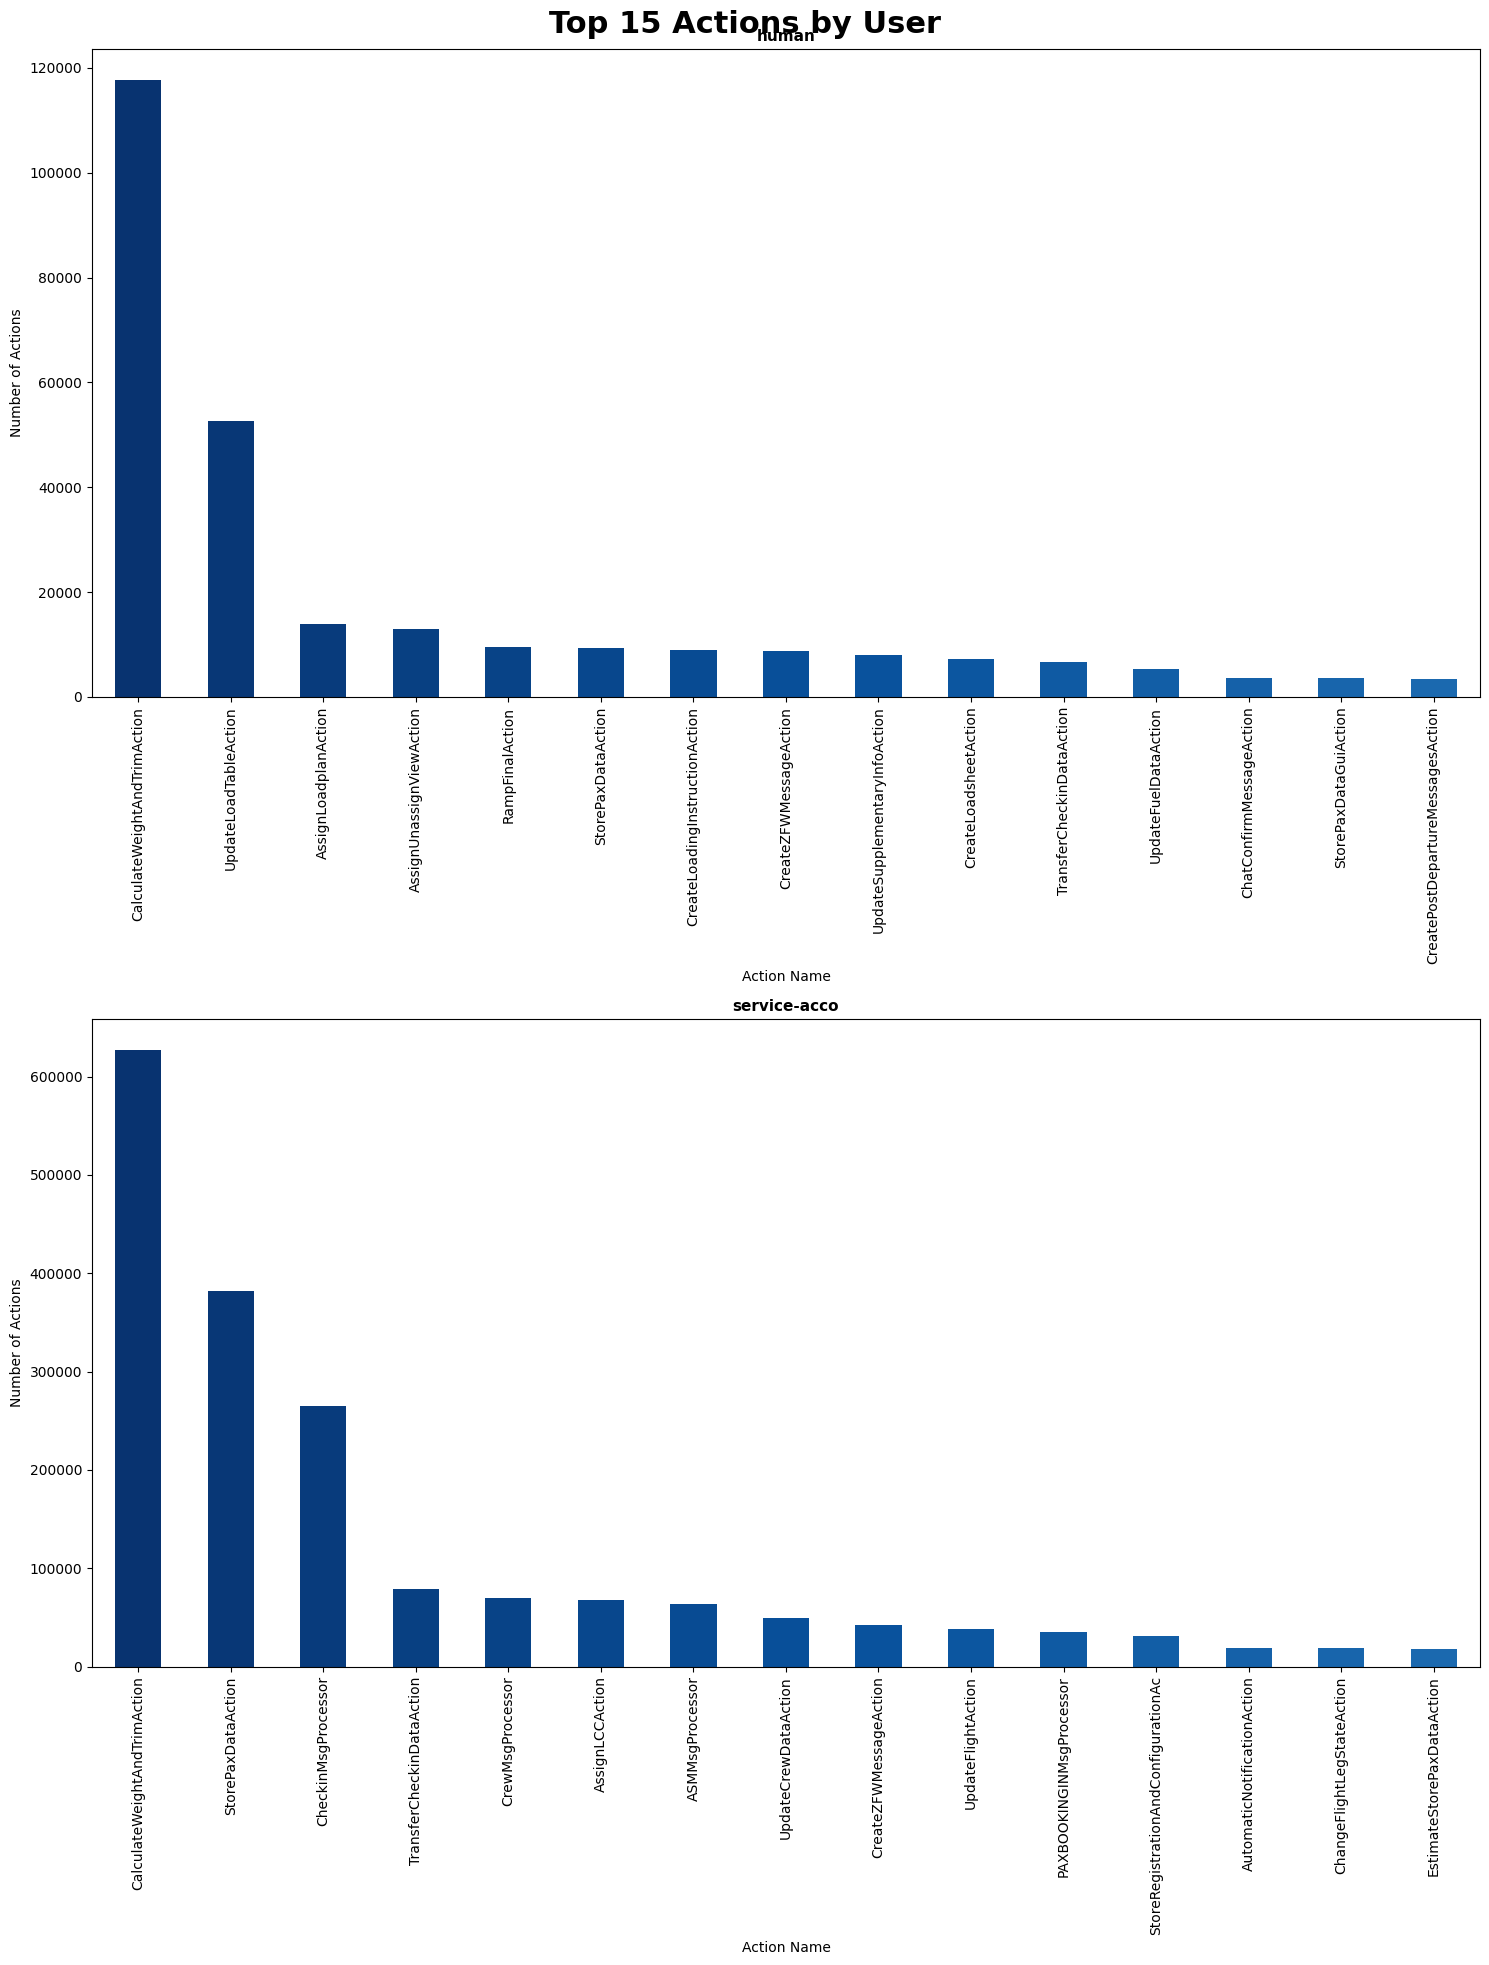

In [10]:
# count actions by type for each user
user_action_counts = data.groupby(['user_name', 'action_name']).size().unstack().fillna(0)

# get the top 15 most frequent actions for each user individually
top_user_actions = user_action_counts.apply(lambda x: x.nlargest(15).index, axis=1)

# create faceted bar charts with separate x-axes for each user's top 15 actions
fig, axes = plt.subplots(len(user_action_counts.index), 1, figsize=(15, 20), sharex=False)

# create a color palette
num_actions = user_action_counts.shape[1]
palette = sns.color_palette("Blues_r", num_actions)

for i, user in enumerate(user_action_counts.index):
    # filter to only the top 15 actions for this user
    top_actions = top_user_actions.loc[user]
    user_data = user_action_counts.loc[user, top_actions]
    
    user_data.plot(kind='bar', ax=axes[i], color=palette[:len(top_actions)])
    axes[i].set_title(user, fontsize = 11, fontweight = 'bold')
    axes[i].set_xlabel('Action Name')
    axes[i].set_ylabel('Number of Actions')
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle('Top 15 Actions by User', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.savefig('./graphics/top_15_action_user.svg', format="svg")

plt.show()

In [11]:
# count actions by type for each user
user_action_counts = data.groupby(['user_name', 'action_name']).size().unstack().fillna(0)

# the total number of actions for each action
total_action_counts = user_action_counts.sum(axis=0)

# the percentage of each user's actions for each action
user_action_percentage = user_action_counts.div(total_action_counts, axis=1) * 100

user_action_percentage

action_name,ASMMsgProcessor,AcceptTransitDataAction,AcceptTransitLoadAction,AcceptTransitNotocAction,AssignLCCAction,AssignLoadplanAction,AssignUnassignViewAction,AutoLoadBulkAction,AutoLoadULDAction,AutomaticNotificationAction,...,UpdateCargoMailEstimatesAction,UpdateCrewDataAction,UpdateEstimatesAction,UpdateFlightAction,UpdateFuelDataAction,UpdateHistoricalFlightLegInfoAction,UpdateLastEzfwSentAction,UpdateLoadTableAction,UpdateSupplementaryInfoAction,UpdateTransitLoadTableAction
user_name,,,,,,,,,,,,,,,,,,,,,
human,0.0,100.0,100.0,100.0,0.651475,69.386439,99.66384,7.189295,56.068268,0.0,...,100.0,2.854323,100.0,0.508546,61.873027,55.362156,70.731707,83.41632,100.0,100.0
service-acco,100.0,0.0,0.0,0.0,99.348525,30.613561,0.33616,92.810705,43.931732,100.0,...,0.0,97.145677,0.0,99.491454,38.126973,44.637844,29.268293,16.58368,0.0,0.0


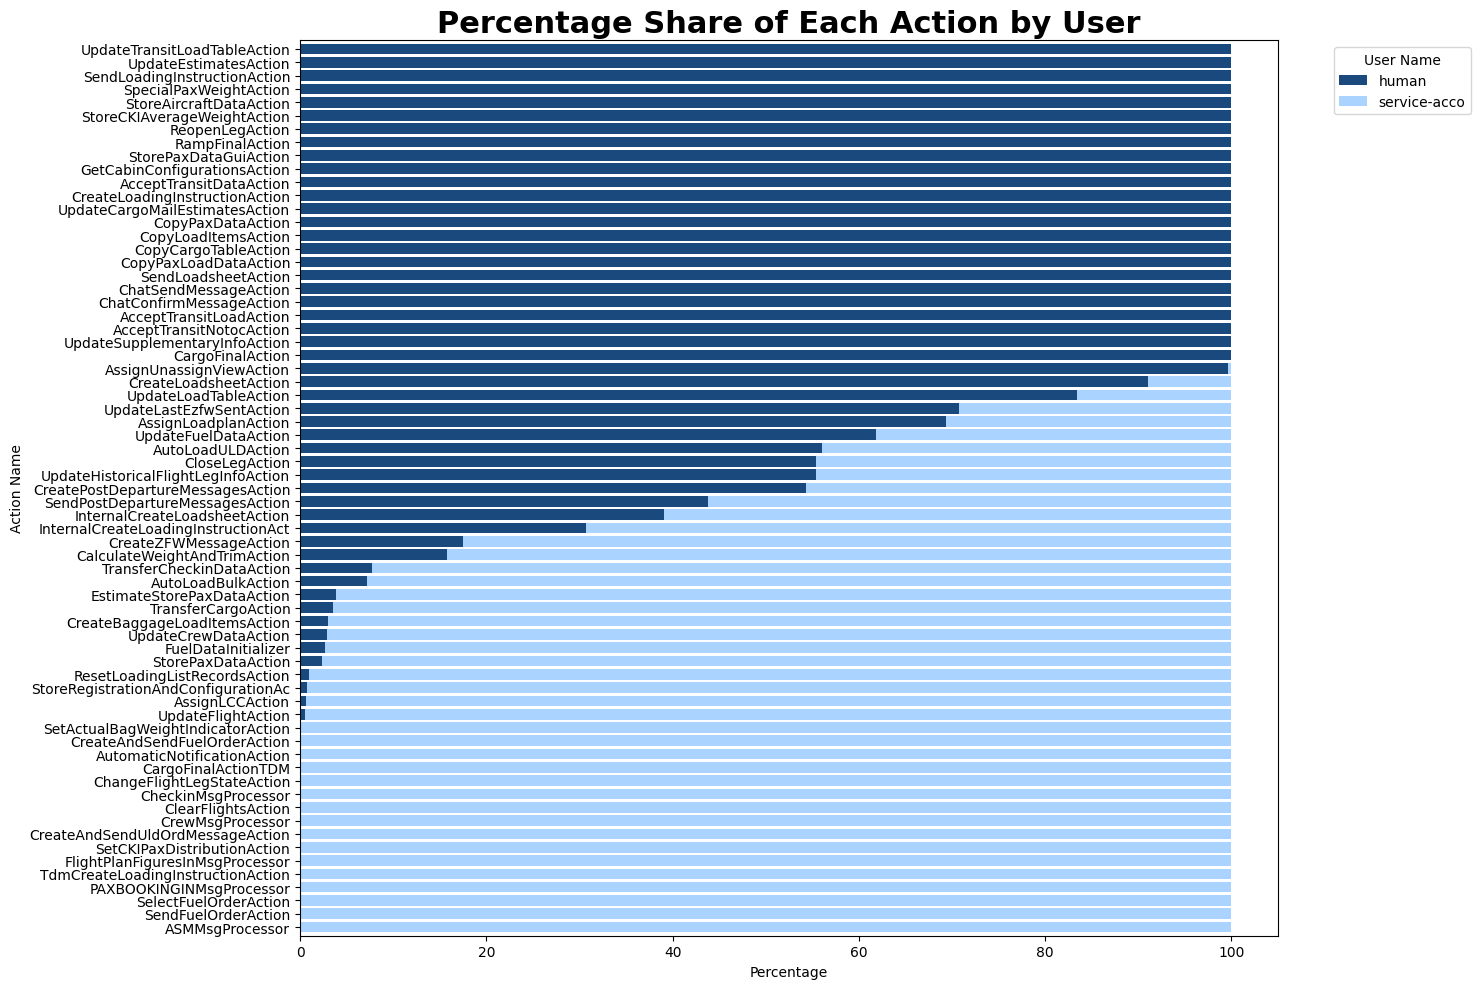

In [12]:
# sort actions by the percentage of 'human' or 'service-acco'
user_to_sort_by = 'human'
sorted_actions = user_action_percentage.T.sort_values(by=user_to_sort_by, ascending=False).index

# plot the percentage share of each action by each user with swapped axes and increased spacing
fig, ax = plt.subplots(figsize=(15, 10))
colors = ['#1a497e', '#AAD4FF']  

user_action_percentage[sorted_actions].T.plot(kind='barh', stacked=True, ax=ax, color=colors, width=0.8)

# title and labels
plt.title('Percentage Share of Each Action by User', fontsize = 22, fontweight = 'bold')
plt.xlabel('Percentage')
plt.ylabel('Action Name')
plt.legend(title='User Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# more spacing between the bars
ax.set_yticks([i for i in range(len(sorted_actions))])
ax.set_yticklabels(sorted_actions, ha='right')
plt.gca().invert_yaxis()

# adjust layout
plt.tight_layout()
plt.savefig('./graphics/action_by_user_ratio.svg', format = "svg")
plt.show()

In [16]:
# count the number of actions included in the visualization
num_actions_in_visualization = len(sorted_actions)

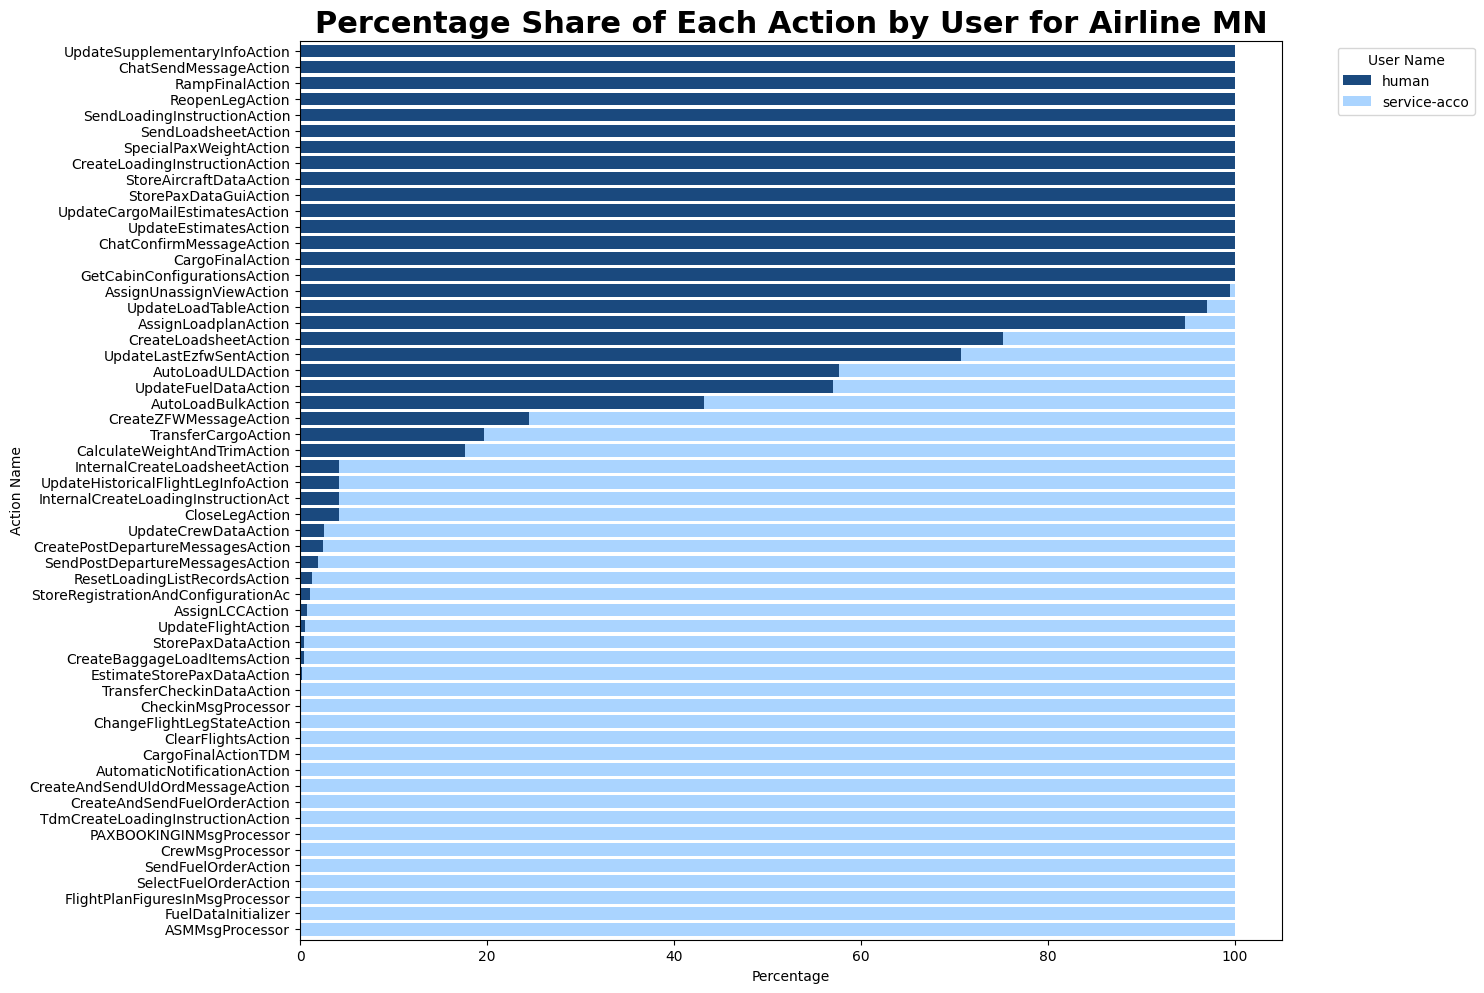

The number of actions included in the visualization for airline MN is: 56


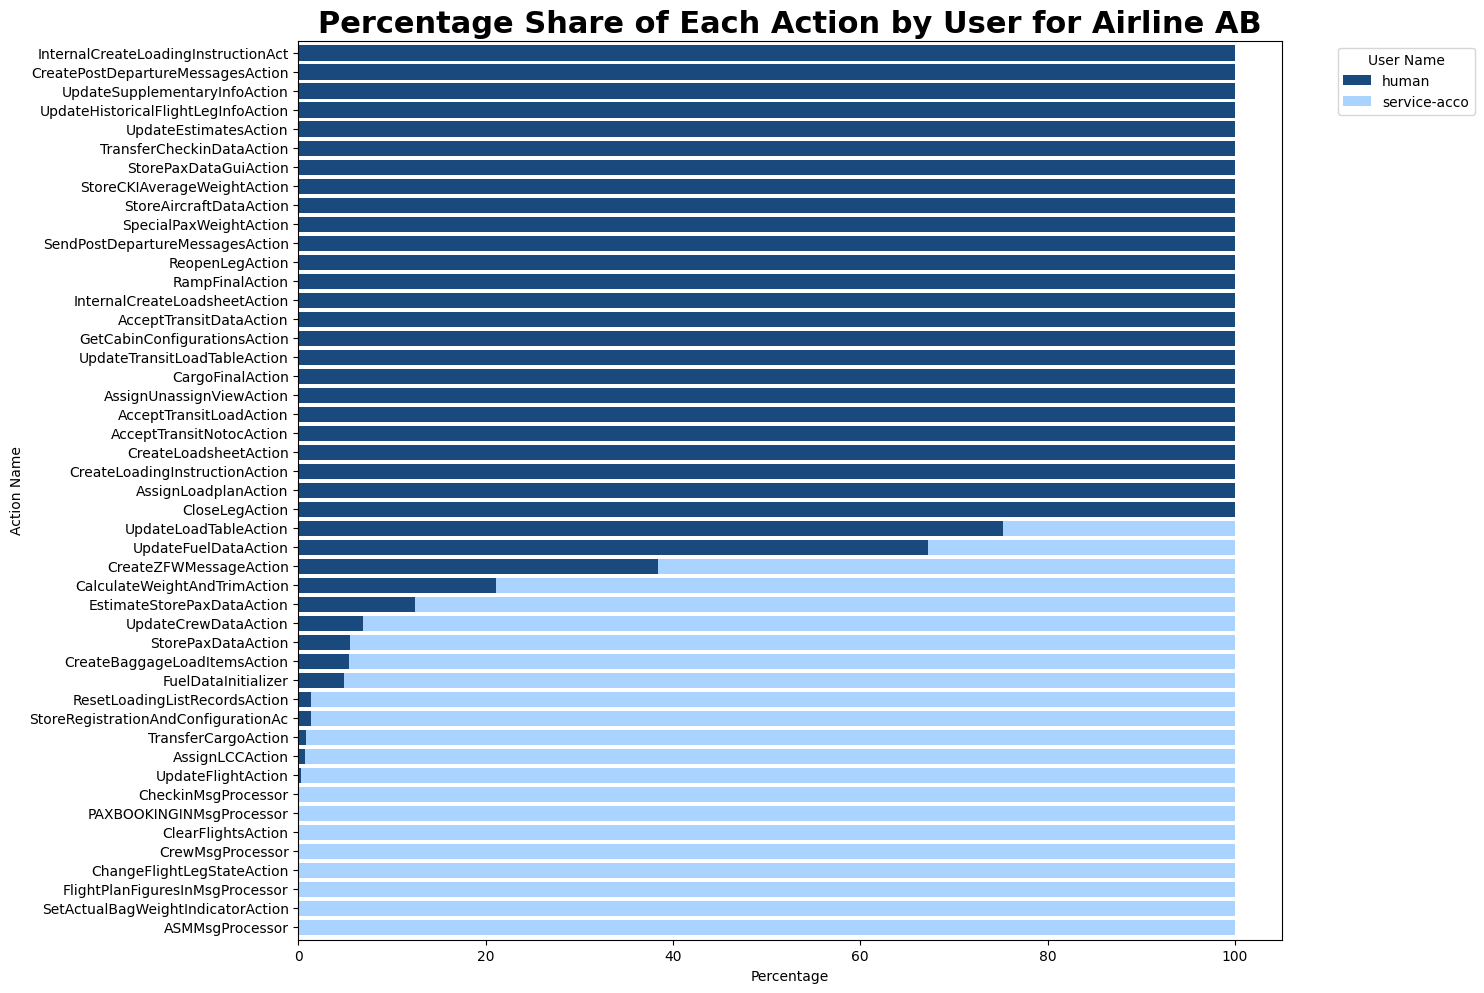

The number of actions included in the visualization for airline AB is: 47


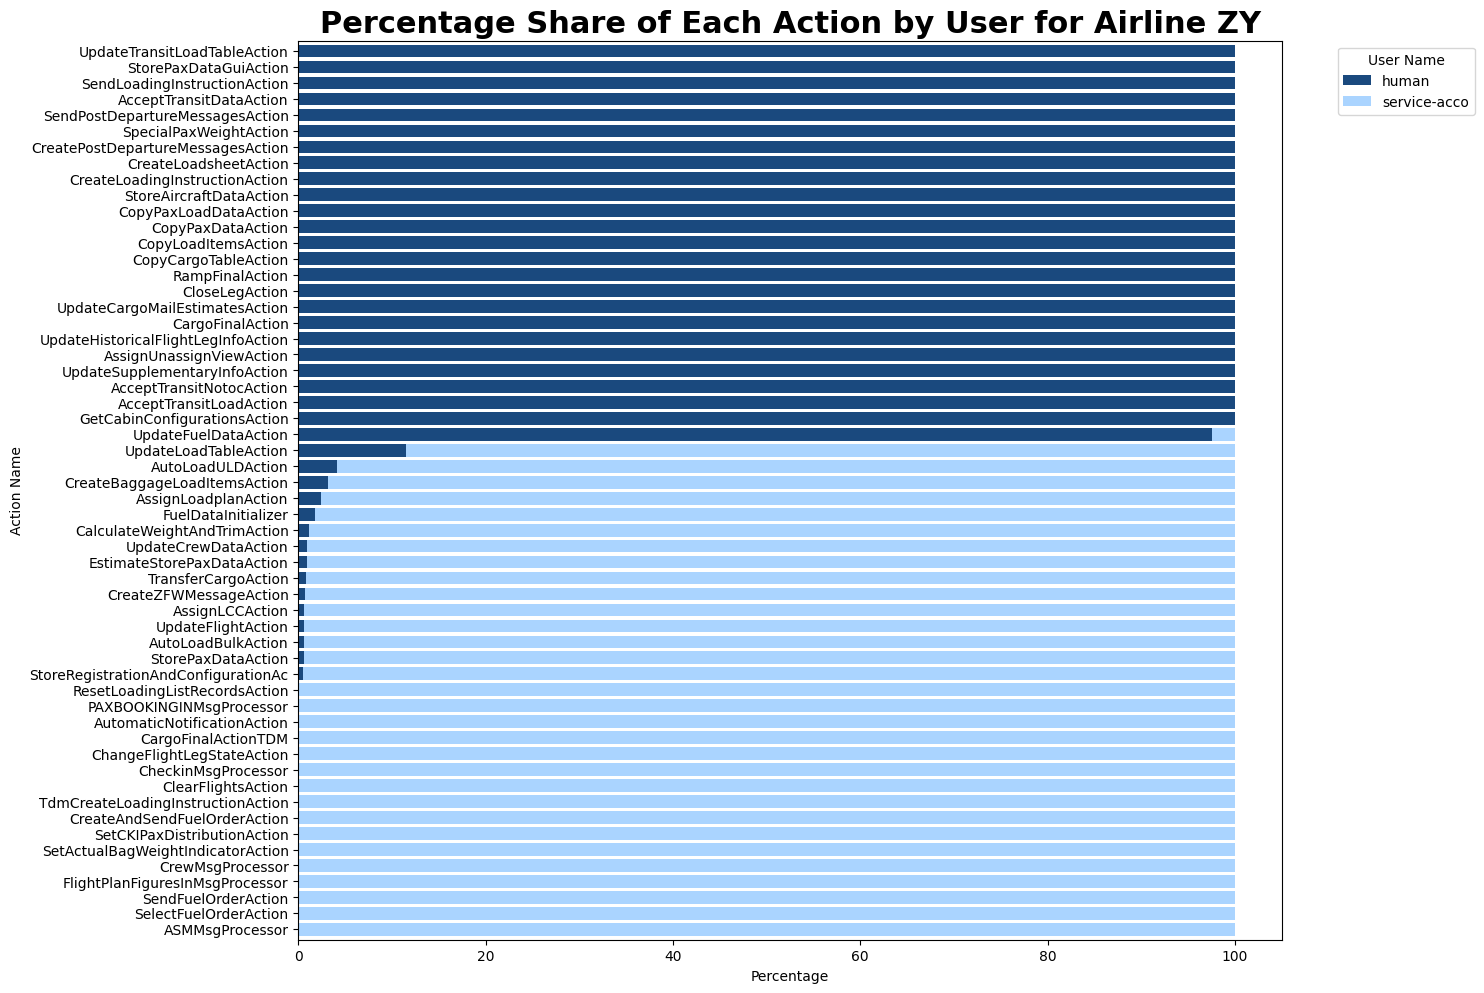

The number of actions included in the visualization for airline ZY is: 56


In [17]:
# make sure 'creation_time' is a datetime column
data['creation_time'] = pd.to_datetime(data['creation_time'])

# get the unique airline codes
airlines = data['airline_code'].unique()

for airline in airlines:
    # filter data for the current airline
    airline_data = data[data['airline_code'] == airline]
    
    # count actions by type for each user
    user_action_counts = airline_data.groupby(['user_name', 'action_name']).size().unstack().fillna(0)

    # the total number of actions for each action
    total_action_counts = user_action_counts.sum(axis=0)

    # the percentage of each user's actions for each action
    user_action_percentage = user_action_counts.div(total_action_counts, axis=1) * 100

    # sort actions by the percentage of 'human' or 'service-acco'
    # choose the user to sort by, for example 'human'
    user_to_sort_by = 'human'
    sorted_actions = user_action_percentage.T.sort_values(by=user_to_sort_by, ascending=False).index

    # plot the percentage share of each action by each user with swapped axes and increased spacing
    fig, ax = plt.subplots(figsize=(15, 10))
    palette = ['#1a497e', '#AAD4FF']  # blue and dark blue colors
    user_action_percentage[sorted_actions].T.plot(kind='barh', stacked=True, ax=ax, color=palette, width=0.8)

    # title and labels
    plt.title(f'Percentage Share of Each Action by User for Airline {airline}', fontsize=22, fontweight='bold')
    plt.xlabel('Percentage')
    plt.ylabel('Action Name')
    plt.legend(title='User Name', bbox_to_anchor=(1.05, 1), loc='upper left')

    # add more spacing between the bars
    ax.set_yticks([i for i in range(len(sorted_actions))])
    ax.set_yticklabels(sorted_actions, ha='right')
    plt.gca().invert_yaxis()

    # adjust layout for more spacing
    plt.tight_layout(pad=0.95)
    plt.show()

    # count the number of actions included in the visualization
    num_actions_in_visualization = len(sorted_actions)
    print(f'The number of actions included in the visualization for airline {airline} is: {num_actions_in_visualization}')

    plt.savefig(f'./graphics/{airline}_action_percentage_share.svg')
    plt.close()


# AB_action_percentage_share.svg
# MN_action_percentage_share.svg
# ZY_action_percentage_share.svg

In [15]:
# a dictionary to hold the dataframes for each airline
airline_percentages = {}

# get the unique airline codes
airlines = data['airline_code'].unique()

for airline in airlines:
    # filter data for the current airline
    airline_data = data[data['airline_code'] == airline]
    
    # count actions by type for each user
    user_action_counts = airline_data.groupby(['user_name', 'action_name']).size().unstack().fillna(0)

    # the total number of actions for each action
    total_action_counts = user_action_counts.sum(axis=0)

    # the percentage of each user's actions for each action
    user_action_percentage = user_action_counts.div(total_action_counts, axis=1) * 100

    # sort actions by the percentage of 'human' or 'service-acco'
    # choose the user to sort by, for example 'human'
    user_to_sort_by = 'human'
    sorted_actions = user_action_percentage.T.sort_values(by=user_to_sort_by, ascending=False).index

    # store dataframe in dict
    airline_percentages[airline] = user_action_percentage[sorted_actions]

    df = user_action_percentage[sorted_actions]
    df.to_csv(f'../data/data_visualization/percentage_share_{airline}.csv')

for airline, df in airline_percentages.items():
    print(f"Percentage Share of Each Action by User for Airline {airline}:")
    display(df)
    print("\n")



Percentage Share of Each Action by User for Airline MN:


action_name,UpdateSupplementaryInfoAction,ChatSendMessageAction,RampFinalAction,ReopenLegAction,SendLoadingInstructionAction,SendLoadsheetAction,SpecialPaxWeightAction,CreateLoadingInstructionAction,StoreAircraftDataAction,StorePaxDataGuiAction,...,CreateAndSendUldOrdMessageAction,CreateAndSendFuelOrderAction,TdmCreateLoadingInstructionAction,PAXBOOKINGINMsgProcessor,CrewMsgProcessor,SendFuelOrderAction,SelectFuelOrderAction,FlightPlanFiguresInMsgProcessor,FuelDataInitializer,ASMMsgProcessor
user_name,,,,,,,,,,,,,,,,,,,,,
human,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
service-acco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0




Percentage Share of Each Action by User for Airline AB:


action_name,InternalCreateLoadingInstructionAct,CreatePostDepartureMessagesAction,UpdateSupplementaryInfoAction,UpdateHistoricalFlightLegInfoAction,UpdateEstimatesAction,TransferCheckinDataAction,StorePaxDataGuiAction,StoreCKIAverageWeightAction,StoreAircraftDataAction,SpecialPaxWeightAction,...,AssignLCCAction,UpdateFlightAction,CheckinMsgProcessor,PAXBOOKINGINMsgProcessor,ClearFlightsAction,CrewMsgProcessor,ChangeFlightLegStateAction,FlightPlanFiguresInMsgProcessor,SetActualBagWeightIndicatorAction,ASMMsgProcessor
user_name,,,,,,,,,,,,,,,,,,,,,
human,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.71578,0.253485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
service-acco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,99.28422,99.746515,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0




Percentage Share of Each Action by User for Airline ZY:


action_name,UpdateTransitLoadTableAction,StorePaxDataGuiAction,SendLoadingInstructionAction,AcceptTransitDataAction,SendPostDepartureMessagesAction,SpecialPaxWeightAction,CreatePostDepartureMessagesAction,CreateLoadsheetAction,CreateLoadingInstructionAction,StoreAircraftDataAction,...,ClearFlightsAction,TdmCreateLoadingInstructionAction,CreateAndSendFuelOrderAction,SetCKIPaxDistributionAction,SetActualBagWeightIndicatorAction,CrewMsgProcessor,FlightPlanFiguresInMsgProcessor,SendFuelOrderAction,SelectFuelOrderAction,ASMMsgProcessor
user_name,,,,,,,,,,,,,,,,,,,,,
human,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
service-acco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
